In [1]:
import pandas as pd
import numpy as np
import pickle
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import save_npz
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
print("--- Downloading NLTK resources (if needed) ---")
try:
    nltk.data.find('corpora/wordnet')
    print("WordNet resource found.")
except LookupError:
    print("WordNet resource not found. Downloading...")
    nltk.download('wordnet', quiet=True)

try:
    nltk.data.find('corpora/omw-1.4')
    print("OMW-1.4 resource found.")
except LookupError:
    print("OMW-1.4 resource not found. Downloading...")
    nltk.download('omw-1.4', quiet=True)

try:
    nltk.data.find('tokenizers/punkt')
    print("Punkt tokenizer resource found.")
except LookupError:
    print("Punkt tokenizer resource not found. Downloading...")
    nltk.download('punkt', quiet=True)

try:
    nltk.data.find('corpora/stopwords')
    print("Stopwords resource found.")
except LookupError:
    print("Stopwords resource not found. Downloading...")
    nltk.download('stopwords', quiet=True)

print("NLTK resources checked/downloaded.")


--- Downloading NLTK resources (if needed) ---
WordNet resource not found. Downloading...
OMW-1.4 resource not found. Downloading...
Punkt tokenizer resource found.
Stopwords resource found.
NLTK resources checked/downloaded.


In [5]:
print("\n--- Loading Data ---")

path_df = "/content/News_dataset.pickle"

with open(path_df, 'rb') as data:
    df = pickle.load(data)
print("DataFrame loaded successfully.")
print(f"Shape of DataFrame: {df.shape}")


--- Loading Data ---
DataFrame loaded successfully.
Shape of DataFrame: (2225, 6)


In [6]:
print("\n--- Exploratory Data Analysis ---")

# 4.1 Basic Info
print("DataFrame Info:")
df.info()

print("\nDataFrame Head:")
print(df.head())

print("\nCheck for Missing Values:")
print(df.isnull().sum())


--- Exploratory Data Analysis ---
DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   File_Name          2225 non-null   object
 1   Content            2225 non-null   object
 2   Category           2225 non-null   object
 3   Complete_Filename  2225 non-null   object
 4   id                 2225 non-null   int64 
 5   News_length        2225 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 104.4+ KB

DataFrame Head:
  File_Name                                            Content  Category  \
0   001.txt  Ad sales boost Time Warner profit\r\n\r\nQuart...  business   
1   002.txt  Dollar gains on Greenspan speech\r\n\r\nThe do...  business   
2   003.txt  Yukos unit buyer faces loan claim\r\n\r\nThe o...  business   
3   004.txt  High fuel prices hit BA's profits\r\n\r\nBriti...  business   
4   005.txt  Perno


Category Distribution:
Category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64




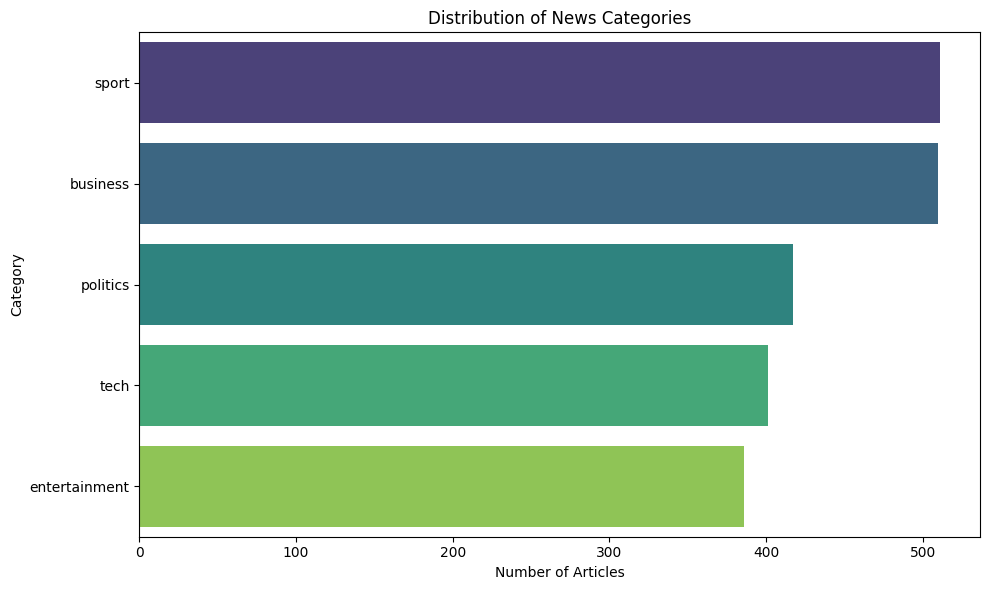


News Length Analysis:




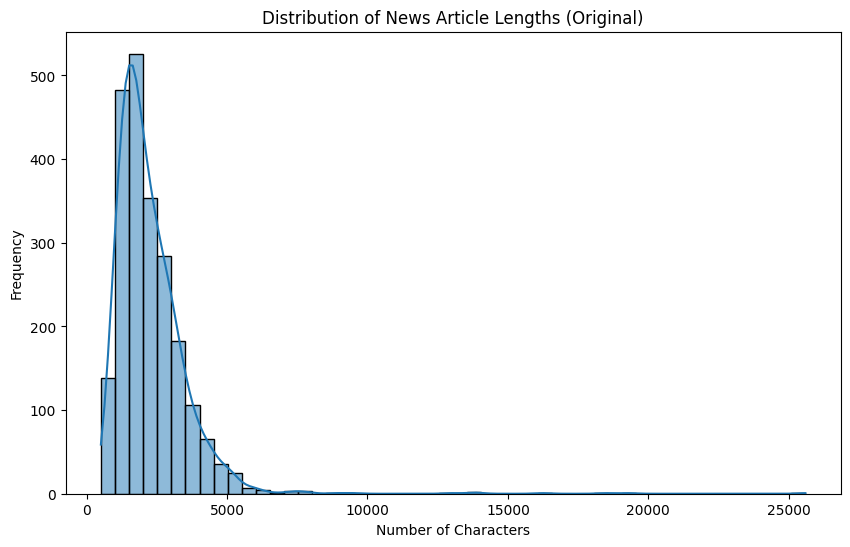

Average news length: 2274.36 characters


In [15]:
print("\nCategory Distribution:")
category_counts = df['Category'].value_counts()
print(category_counts)
print("\n")

plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='Category', order=category_counts.index, palette='viridis')
plt.title('Distribution of News Categories')
plt.xlabel('Number of Articles')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

# 4.3 News Length Analysis (using existing 'News_length' column)
print("\nNews Length Analysis:\n\n")
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='News_length', kde=True, bins=50)
plt.title('Distribution of News Article Lengths (Original)')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

print(f"Average news length: {df['News_length'].mean():.2f} characters")

In [9]:
nltk.download("punkt_tab")
print("\n--- Performing Text Preprocessing ---")

# Initialize Lemmatizer and Stopwords list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    # 2. Remove punctuation and numbers (keep only letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    # 3. Tokenize
    words = word_tokenize(text)
    # 4. Remove Stop Words and Lemmatize
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2] # Keep words > 2 chars
    # 5. Join back into string
    return ' '.join(lemmatized_words)

# Apply the preprocessing function to the 'Content' column
# Using .copy() to avoid SettingWithCopyWarning
df_processed = df.copy()
print("Applying preprocessing to 'Content' column...")
df_processed['Cleaned_Content'] = df_processed['Content'].apply(preprocess_text)
print("Preprocessing complete.")

# Display comparison for one example
print("\nOriginal Content (first row):")
print(df.iloc[0]['Content'][:500] + "...") # Show first 500 chars
print("\nCleaned Content (first row):")
print(df_processed.iloc[0]['Cleaned_Content'][:500] + "...")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



--- Performing Text Preprocessing ---
Applying preprocessing to 'Content' column...
Preprocessing complete.

Original Content (first row):
Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.
...

Cleaned Content (first row):
sale boost time warner profit quarterly profit medium giant timewarner jumped three month december yearearlier firm one biggest investor google benefited sale highspeed internet connection higher advert sale timewarner said fourth quarter sale rose profit buoyed oneoff gain offset profit dip warner bros less user aol time warner s

In [10]:
print("\n--- Performing Label Encoding on 'Category' ---")
label_encoder = LabelEncoder()

# Apply Label Encoding
df_processed['Category_Encoded'] = label_encoder.fit_transform(df_processed['Category'])

# Display mapping
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Category to Encoded Label Mapping:")
print(category_mapping)

print("\nDataFrame Head with Processed Columns:")
print(df_processed[['Category', 'Category_Encoded', 'Cleaned_Content']].head())


--- Performing Label Encoding on 'Category' ---
Category to Encoded Label Mapping:
{'business': np.int64(0), 'entertainment': np.int64(1), 'politics': np.int64(2), 'sport': np.int64(3), 'tech': np.int64(4)}

DataFrame Head with Processed Columns:
   Category  Category_Encoded  \
0  business                 0   
1  business                 0   
2  business                 0   
3  business                 0   
4  business                 0   

                                     Cleaned_Content  
0  sale boost time warner profit quarterly profit...  
1  dollar gain greenspan speech dollar hit highes...  
2  yukos unit buyer face loan claim owner embattl...  
3  high fuel price hit ba profit british airway b...  
4  pernod takeover talk lift domecq share drink f...  


In [11]:
print("\n--- Creating TF-IDF Representations ---")

tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limit features to top 5000 for efficiency

# Fit and transform the cleaned text data
tfidf_matrix = tfidf_vectorizer.fit_transform(df_processed['Cleaned_Content'])

print(f"Shape of TF-IDF matrix: {tfidf_matrix.shape}")
print(f"(Number of documents: {tfidf_matrix.shape[0]}, Number of unique terms/features: {tfidf_matrix.shape[1]})")



--- Creating TF-IDF Representations ---
Shape of TF-IDF matrix: (2225, 5000)
(Number of documents: 2225, Number of unique terms/features: 5000)


In [13]:
print("\n--- Saving Processed Data and TF-IDF Objects ---")

# Define output paths (adjust as needed, Kaggle uses /kaggle/working/)
output_dir = "/content"
processed_df_path = output_dir + "processed_news_data.pkl"
tfidf_matrix_path = output_dir + "tfidf_matrix.npz"
tfidf_vectorizer_path = output_dir + "tfidf_vectorizer.pkl"
label_encoder_path = output_dir + "label_encoder.pkl"

# Save the processed DataFrame
df_processed.to_pickle(processed_df_path)
print(f"Processed DataFrame saved to: {processed_df_path}")

# Save the TF-IDF matrix (sparse format)
save_npz(tfidf_matrix_path, tfidf_matrix)
print(f"TF-IDF matrix saved to: {tfidf_matrix_path}")

# Save the TF-IDF vectorizer
with open(tfidf_vectorizer_path, 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print(f"TF-IDF vectorizer saved to: {tfidf_vectorizer_path}")

# Save the Label Encoder
with open(label_encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"Label encoder saved to: {label_encoder_path}")

print("\n--- All Steps Completed Successfully ---")


--- Saving Processed Data and TF-IDF Objects ---
Processed DataFrame saved to: /contentprocessed_news_data.pkl
TF-IDF matrix saved to: /contenttfidf_matrix.npz
TF-IDF vectorizer saved to: /contenttfidf_vectorizer.pkl
Label encoder saved to: /contentlabel_encoder.pkl

--- All Steps Completed Successfully ---
